**Import packages from Keras**

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import cv2

########### Load Keras Modules Needed ==========================================
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model, Model

from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, \
                                    concatenate, average, add, Reshape, Permute, Conv2D, \
                                    Conv2DTranspose, SeparableConv2D,PReLU, ELU, \
                                    BatchNormalization, \
                                    MaxPooling2D, ZeroPadding2D, UpSampling2D, \
                                    AveragePooling2D,Cropping2D, \
                                    Flatten, Dense, Dropout, Activation, Reshape,\
                                    SpatialDropout2D,Average


from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping,\
                            LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model,to_categorical,Sequence



# Load other functions ==================================================
from random import randint, choice, shuffle, sample
from itertools import product

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



from sklearn.metrics import confusion_matrix
from sklearn import metrics


**Load and visualize images**

In [53]:
imgpath = '/content/drive/MyDrive/Fauna classification/Asirra/'
img_list = sorted(glob.glob(imgpath+'*.jpg'))

print("number of images in the directory: ",np.shape(img_list))
print(img_list[:2])

number of images in the directory:  (200,)
['/content/drive/MyDrive/Fauna classification/Asirra/cat.10.jpg', '/content/drive/MyDrive/Fauna classification/Asirra/cat.100.jpg']


In [54]:
@interact(x=(0,len(img_list)-1,1)) #Function responsible for creating the slider. Usage format @interact(start,end,step size)                  

def h(x=0): #Starting number of the slider

  img = Image.open(img_list[x])

  f = plt.figure(figsize=(6,6))
  plt.imshow(img)
  plt.show()



interactive(children=(IntSlider(value=0, description='x', max=199), Output()), _dom_classes=('widget-interact'…

**Convert images to numpy array and create labels for images**

In [55]:
img_H = 200
img_W = 200

In [56]:
img_np = []
label_np = []

for i in range(len(img_list)):
    img = Image.open(img_list[i])
    img = img.resize((img_H,img_W))
    img = np.asarray(img)
    img = (img-np.min(img))/(np.max(img)-np.min(img))
    img_np.append(img)

    name = (img_list[i].split("/")[-1]).split('.')[0]
    label = np.array([0,1]) if name == 'cat' else np.array([1,0]) # 0 for dog and 1 for cat
    label_np.append(label)
    
img_np = np.array(img_np,dtype=np.float32)
label_np = np.array(label_np,dtype=np.uint8)
    
print("number of images and labels: ",np.shape(img_np), np.shape(label_np))


number of images and labels:  (200, 200, 200, 3) (200, 2)


In [57]:
@interact(x=(0,len(img_np)-1,1)) #Function responsible for creating the slider. Usage format @interact(start,end,step size)                  

def h(x=0): #Starting number of the slider
  print(label_np[x])
  f = plt.figure(figsize=(6,6))
  plt.imshow(img_np[x],cmap='gray')
  plt.show()

interactive(children=(IntSlider(value=0, description='x', max=199), Output()), _dom_classes=('widget-interact'…

**shuffle images to create a random dataset**

In [58]:
    
zipimgs=list(zip(img_np,label_np)) #zip the labels  and image data
shuffle(zipimgs) #shuffle the data
img_np,label_np = zip(*zipimgs)
print("number of images and labels after shuffle: ",np.shape(img_np), np.shape(label_np))

number of images and labels after shuffle:  (200, 200, 200, 3) (200, 2)


In [59]:
@interact(x=(0,len(img_np)-1,1)) #Function responsible for creating the slider. Usage format @interact(start,end,step size)                  

def h(x=0): #Starting number of the slider
  print(label_np[x])
  f = plt.figure(figsize=(6,6))
  plt.imshow(img_np[x],cmap='gray')
  plt.show()

interactive(children=(IntSlider(value=0, description='x', max=199), Output()), _dom_classes=('widget-interact'…

**Create train, validation, and test set**

In [60]:
train_imgs  =img_np[0:150]
train_labels=np.array(label_np[0:150])

val_imgs  =img_np[150:170]
val_labels=np.array(label_np[150:170])

test_imgs  =img_np[170:200]
test_labels=np.array(label_np[170:200])

train_images=train_imgs #np.expand_dims(train_imgs,axis=3)
val_images=val_imgs #np.expand_dims(val_imgs,axis=3)
test_images=test_imgs #np.expand_dims(test_imgs,axis=3)

print('\nTraining data dimension: {} for labels and {} for images'.format(np.shape(train_labels),np.shape(train_images)))
print('\nValidation data dimension: {} for labels and {} for images'.format(np.shape(val_labels),np.shape(val_images)))
print('\nTesting data dimension: {} for labels and {} for images'.format(np.shape(test_labels),np.shape(test_images)))



Training data dimension: (150, 2) for labels and (150, 200, 200, 3) for images

Validation data dimension: (20, 2) for labels and (20, 200, 200, 3) for images

Testing data dimension: (30, 2) for labels and (30, 200, 200, 3) for images


**Create a network**

In [61]:
# from keras.applications.inception_v3 import InceptionV3
# # load model
# model = VGG19()
# # summarize the model
# model.summary()

In [62]:
# from keras.applications.inception_v3 import InceptionV3
# # load model
# model = InceptionV3()
# # summarize the model
# model.summary()

In [63]:
# # example of loading the resnet50 model
# from keras.applications.resnet50 import ResNet50
# # load model
# model = ResNet50()
# # summarize the model
# model.summary()

In [64]:
def NeuralNet():
  baseModel = tf.keras.applications.VGG19(weights="imagenet", 
                                      include_top= False,
                                      input_shape=(img_H, img_W, 3))

  for layer in baseModel.layers:
      layer.trainable = False

  headModel = baseModel.output
  headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dense(64, activation="relu")(headModel)
  headModel = Dropout(0.4)(headModel)
  headModel = Dense(2, activation="softmax")(headModel)
  model = Model(inputs=baseModel.input, outputs=headModel)

  return model


In [65]:
Adam= tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False) 
sgd_1=SGD(learning_rate=0.005, momentum=0.05, decay=0.01, nesterov=False)

model = NeuralNet()

model.compile(optimizer = sgd_1, loss = 'categorical_crossentropy', metrics = ['accuracy']) 

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0   

**Specify a path to save the model during training**

In [72]:
testname = 'Asirra'
best_checkpoint=ModelCheckpoint(filepath=imgpath+'/Model_checkpoints/best_weights_'+testname+'.hdf5',
                             monitor='val_loss',verbose=1, 
                             save_best_only=True, save_weights_only=True, mode='auto', period=1)

cur_checkpoint=ModelCheckpoint(filepath=imgpath+'/Model_checkpoints/cur_weights_'+testname+'.hdf5',
                             monitor='val_loss',verbose=0, 
                             save_best_only=False, save_weights_only=True, mode='auto', period=1)



**Function for data generation**

In [73]:
def DataGen(X, y, batch_sz):

  c = list(zip(X, y))
  shuffle(c)
  X, y = zip(*c)
  
  Xpatches = np.ndarray((batch_sz, img_H, img_W, 3))
  ypatches = np.ndarray((batch_sz, 2), dtype=np.uint8)  

          
  image_index = 0
  batch_index = 0
  while (True):

    if image_index >= len(X):
          image_index = 0

    #if the batch is full, release the batch
    if batch_index == batch_sz:
        batch_index = 0
        yield Xpatches, ypatches
        
    ax, ay = np.copy(X[image_index]), np.copy(y[image_index])


    #flip with probability 1/2
    if randint(0, 1):
        ax = ax[:, ::-1, :]

    # horizontal and vertical shift
    if True:
      croph, cropw = img_H,img_W
      M = np.float32([[1,0,np.random.uniform(low=-15, high=15)],[0,1,np.random.uniform(low=-15, high=15)]]) # horizontal , vertical
      ax[:,:,:] = cv2.warpAffine(ax[:,:,:],M,(cropw,croph))
            
    # Rotate 
    if True:
        rotation_matrix = cv2.getRotationMatrix2D((cropw/2, croph/2), np.random.uniform(low=-10, high=10), 1)
        ax[:,:,:] = cv2.warpAffine( ax[:,:,:], rotation_matrix, (cropw, croph))
    
    #Intensity nonlinear shift
    if True:
        p = np.random.uniform(low=0.6, high=1.4)
        ax[:,:,:] = ax[:,:,:]**p
        a = np.random.uniform(low=0, high=0.1)
        b = np.random.uniform(low=0, high=0.1)
        ax[:,:,:] = -a + (1+a+b) * ax[:,:,:]
        ax = np.clip(ax, 0., 1.)


    
    #make sure that pixel intensity is in [0,1] and labels are integers
    ax = np.clip(ax, 0., 1.)
    ay = np.clip(ay, 0., 1.)
    ay = np.rint(ay)



    Xpatches[batch_index] = ax
    ypatches[batch_index] = ay
    
    batch_index = batch_index + 1
    image_index = image_index + 1

In [74]:
def DataGenTest(X, y, batch_sz):

  c = list(zip(X, y))
  shuffle(c)
  X, y = zip(*c)
  
  Xpatches = np.ndarray((batch_sz, img_H, img_W, 3))
  ypatches = np.ndarray((batch_sz, 2), dtype=np.uint8)  

          
  image_index = 0
  batch_index = 0
  while (True):

    if image_index >= len(X):
          image_index = 0

    #if the batch is full, release the batch
    if batch_index == batch_sz:
        batch_index = 0
        yield Xpatches, ypatches
        
    ax, ay = np.copy(X[image_index]), np.copy(y[image_index])

    
    #make sure that pixel intensity is in [0,1] and labels are integers
    ax = np.clip(ax, 0., 1.)
    ay = np.clip(ay, 0., 1.)
    ay = np.rint(ay)



    Xpatches[batch_index] = ax
    ypatches[batch_index] = ay
    
    batch_index = batch_index + 1
    image_index = image_index + 1

In [75]:
# Generate augmentation 
batch_sz = 5
training_gen = DataGen(train_images, train_labels, batch_sz)


im,labl = next(training_gen)
print("Dim(image)=",np.shape(im), labl)


@interact(x=(0,len(im)-1,1)) #Function responsible for creating the slider. Usage format @interact(start,end,step size)                  

def h(x=0): #Starting number of the slider
  print(labl[x])

  f = plt.figure(figsize=(6,6))
  plt.imshow(im[x])
  plt.show()

Dim(image)= (5, 200, 200, 3) [[0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]]


interactive(children=(IntSlider(value=0, description='x', max=4), Output()), _dom_classes=('widget-interact',)…

**Start training**

In [76]:
epochs=400

train_mini_batch_sz =4
val_mini_batch_sz = 2


In [77]:
training_gen = DataGen(train_images, train_labels,train_mini_batch_sz) 
val_gen = DataGen(val_images, val_labels, val_mini_batch_sz)

steps_epoch= 50 #  len(train_images)/ train_mini_batch_sz
val_steps= 5 #   len(val_images)/ val_mini_batch_sz 

fit_history = model.fit_generator(generator=training_gen,
                    steps_per_epoch=steps_epoch,
                    epochs=epochs, 
                    validation_data=val_gen, 
                    validation_steps=val_steps,
                    verbose=1,
                    callbacks=[best_checkpoint, cur_checkpoint])


Epoch 1/400
 2/50 [>.............................] - ETA: 3s - loss: 0.9109 - accuracy: 0.1250

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


49/50 [============================>.] - ETA: 0s - loss: 0.7634 - accuracy: 0.4541
Epoch 1: val_loss improved from inf to 0.65878, saving model to /content/drive/MyDrive/Fauna classification/Asirra//Model_checkpoints/best_weights_Asirra.hdf5
50/50 [==============================] - 6s 118ms/step - loss: 0.7608 - accuracy: 0.4600 - val_loss: 0.6588 - val_accuracy: 0.5000
Epoch 2/400
49/50 [============================>.] - ETA: 0s - loss: 0.7040 - accuracy: 0.5510
Epoch 2: val_loss improved from 0.65878 to 0.65841, saving model to /content/drive/MyDrive/Fauna classification/Asirra//Model_checkpoints/best_weights_Asirra.hdf5
50/50 [==============================] - 3s 52ms/step - loss: 0.7062 - accuracy: 0.5450 - val_loss: 0.6584 - val_accuracy: 0.7000
Epoch 3/400
49/50 [============================>.] - ETA: 0s - loss: 0.7152 - accuracy: 0.4796
Epoch 3: val_loss did not improve from 0.65841
50/50 [==============================] - 2s 45ms/step - loss: 0.7145 - accuracy: 0.4850 - val_los

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


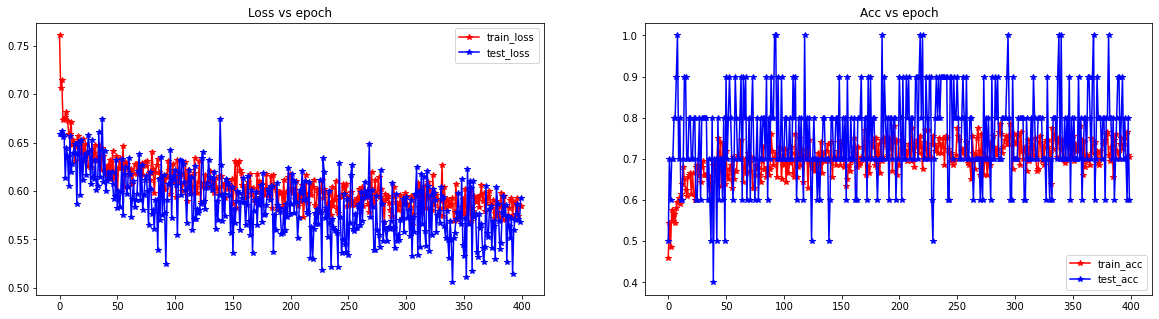

In [78]:
print(fit_history.history.keys())
plt.rcParams['figure.figsize'] = (20,5)

plt.subplot(1,2,1)
plt.title("Loss vs epoch")
plt.plot(fit_history.history["loss"], "r-*", label='train_loss')
plt.plot(fit_history.history["val_loss"], "b-*", label='test_loss')
plt.legend()


plt.subplot(1,2,2)
plt.title("Acc vs epoch")
plt.plot(fit_history.history["accuracy"], "r-*", label='train_acc')
plt.plot(fit_history.history["val_accuracy"], "b-*", label='test_acc')
plt.legend()


In [79]:
model.save(imgpath+'Model_checkpoints/'+testname+'.h5') 
print('FINISHED!!!!!!!')

FINISHED!!!!!!!


In [80]:
model.load_weights(imgpath+'/Model_checkpoints/best_weights_'+testname+'.hdf5')

# model.load_weights(imgpath+'../Model_checkpoints/Server_best_weights_'+testname+'.hdf5')


print('model loaded successfully')

model loaded successfully


# Prediction on test set

In [81]:
# print((test_labels))
print(np.shape(test_labels))
print(np.shape(test_images))

(30, 2)
(30, 200, 200, 3)


In [82]:
batch_size =5
test_preds=model.predict_generator(DataGenTest(test_images,test_labels, batch_size),steps=len(test_images)//batch_size)

print('predictions obtained............')
print(np.shape(test_preds))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


predictions obtained............
(30, 2)


In [83]:
for i in range(len(test_preds)):
  print(test_labels[i],test_preds[i])

[0 1] [0.5701214  0.42987862]
[0 1] [0.57519007 0.4248099 ]
[1 0] [0.39975598 0.600244  ]
[0 1] [0.3183472 0.6816528]
[0 1] [0.39837345 0.6016266 ]
[0 1] [0.55660033 0.44339967]
[1 0] [0.6048588  0.39514118]
[1 0] [0.6625982  0.33740178]
[0 1] [0.546119   0.45388106]
[1 0] [0.43521562 0.5647844 ]
[1 0] [0.51449156 0.48550847]
[0 1] [0.41481924 0.58518076]
[1 0] [0.368042 0.631958]
[1 0] [0.38322836 0.61677164]
[0 1] [0.58036274 0.41963723]
[0 1] [0.41751784 0.5824822 ]
[0 1] [0.54795235 0.45204765]
[0 1] [0.5887696 0.4112304]
[1 0] [0.37127268 0.6287273 ]
[1 0] [0.47800612 0.5219938 ]
[1 0] [0.42383784 0.57616216]
[1 0] [0.72893876 0.27106124]
[1 0] [0.45137072 0.5486293 ]
[1 0] [0.5748329 0.4251671]
[1 0] [0.6824119  0.31758806]
[1 0] [0.30009827 0.69990176]
[1 0] [0.5433326  0.45666742]
[1 0] [0.6536412  0.34635872]
[0 1] [0.31938025 0.6806198 ]
[1 0] [0.6950289  0.30497116]


In [84]:
count = 0
for i in range(len(test_preds)):
  print(test_labels[i,0],test_preds[i,0])
  if test_labels[i,0] == np.round(test_preds[i,0]):
    count = count+1
                              
print(count)

0 0.5701214
0 0.57519007
1 0.39975598
0 0.3183472
0 0.39837345
0 0.55660033
1 0.6048588
1 0.6625982
0 0.546119
1 0.43521562
1 0.51449156
0 0.41481924
1 0.368042
1 0.38322836
0 0.58036274
0 0.41751784
0 0.54795235
0 0.5887696
1 0.37127268
1 0.47800612
1 0.42383784
1 0.72893876
1 0.45137072
1 0.5748329
1 0.6824119
1 0.30009827
1 0.5433326
1 0.6536412
0 0.31938025
1 0.6950289
14


# Plot area under curve

 AUC is  0.5555555555555555


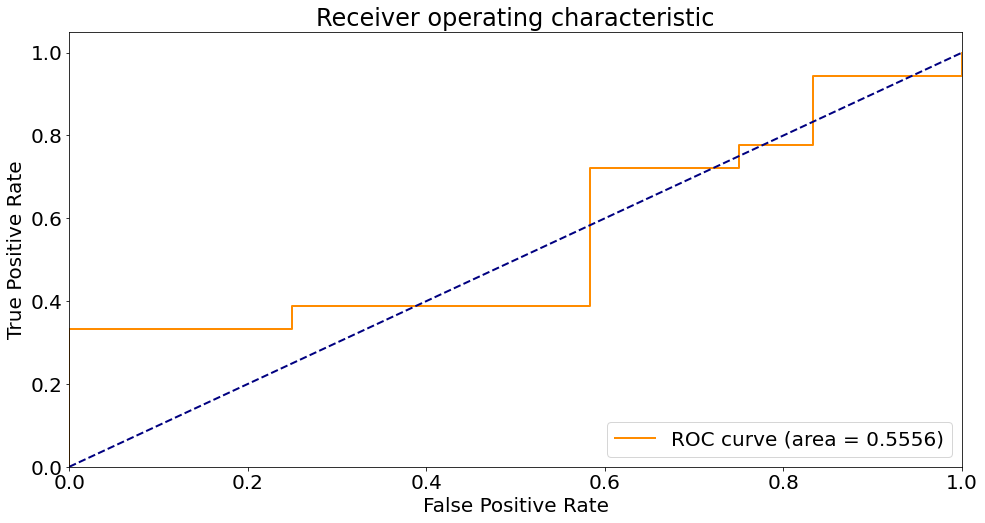

In [85]:
fpr, tpr, thresholds = metrics.roc_curve(test_labels[:,0], test_preds[:,0])
roc_auc=metrics.auc(fpr, tpr)
print(" AUC is ",roc_auc)

plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.title('Receiver operating characteristic',fontsize=24)
plt.legend(loc="lower right",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()


# plot_confusion_matrix#

In [86]:
def plot_confusion_matrix( cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)    
    for iii in range(len(cm)):
        print('accuracy stage {}: {} out of {}, '.format(iii,cm[iii,iii],np.sum(cm[iii,:])) ,cm[iii,iii]/(np.sum(cm[iii,:])))     #....
        
    print('accuracy all: {} out of {},'.format(np.trace(cm),np.sum(cm)),(np.trace(cm))/np.sum(cm))

    
        

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[5 7]
 [9 9]]
accuracy stage 0: 5 out of 12,  0.4166666666666667
accuracy stage 1: 9 out of 18,  0.5
accuracy all: 14 out of 30, 0.4666666666666667


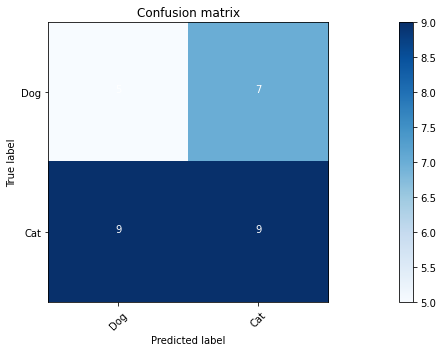

In [87]:
cm = confusion_matrix(test_labels[:,0],np.round(test_preds[:,0]))
cm_plot_labels=['Dog','Cat']
plot_confusion_matrix(cm,cm_plot_labels)

# Let us check the wrongly classified image

In [88]:
@interact(x=(0,len(test_images)-1,1)) #Function responsible for creating the slider. Usage format @interact(start,end,step size)                  

def h(x=0): #Starting number of the slider
  print(test_labels[x],test_preds[x],np.round(test_preds[x][0]))

 

  f = plt.figure(figsize=(6,6))
  plt.imshow(test_images[x])
  plt.show()


interactive(children=(IntSlider(value=0, description='x', max=29), Output()), _dom_classes=('widget-interact',…